一、复杂样例：旅行商问题 (TSP)
问题描述：
假设有一个推销员，需要访问 N 个城市。他从一个城市出发，必须访问所有城市一次且仅一次，最后回到出发的城市。问题是：他应该按照什么样的顺序访问这些城市，才能使他走的总路程最短？
为什么这个问题很复杂？
组合爆炸：对于 N 个城市，总共有 (N-1)! / 2 条可能的路径。当 N=5 时，有12条；N=10时，有18万多条；而当 N=30 时，这个数字已经是一个天文数字了（大约是 1.3 x 10^30），用计算机暴力穷举所有可能性是绝对不可能的。
巨大的解空间：每个合法的路径都是一个潜在的解。
大量的局部最优解：很容易找到一条“看起来还不错”的路径（比如下图中的“初始随机路径”），但这条路径很可能是一个局部最优解，与全局最优解（最短路径）相差甚远。
这正是模拟退火算法大显身手的地方。

二、模拟退火如何解决 TSP？
解 (Solution)：一条访问所有城市的路径（例如 [城市A, 城市C, 城市B, 城市D]）。
成本函数 (Cost Function)：该路径的总长度。我们的目标是让这个值最小化。
邻近解的生成：如何从当前路径得到一个“稍微不同”的新路径？最简单有效的方法是随机交换路径中的两个城市。比如，将 [A, C, B, D] 中的 C 和 B 交换，得到新路径 [A, B, C, D]。这个操作非常简单，但足以用来探索整个解空间。
算法过程：
从一条随机路径开始。
在高温下，算法非常“大胆”，即使交换两个城市后路径变长了（一个“坏”的移动），也很可能接受这个新路径，从而有机会跳出当前的局部最优陷阱。
随着温度慢慢降低，算法变得越来越“保守”，它会越来越倾向于只接受那些能让路径变短的交换。
当温度降到很低时，算法基本不再接受任何使路径变长的交换，只会在当前找到的较优路径附近做一些微调，进行最后的优化。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# --- 1. 定义问题和模拟退火的超参数 ---
NUM_CITIES = 30           # 城市数量
INITIAL_TEMP = 1000       # 初始温度
FINAL_TEMP = 1e-3         # 终止温度
ALPHA = 0.995             # 降温速率
ITERS_PER_TEMP = 500      # 每个温度下的迭代次数

# --- 2. 随机生成城市坐标 ---
# 在一个100x100的区域内随机生成城市
cities = np.random.rand(NUM_CITIES, 2) * 100

In [ ]:

# --- 3. 核心函数 ---
def calculate_total_distance(path, cities):
    """计算给定路径的总距离"""
    total_dist = 0
    for i in range(len(path)):
        # 计算当前城市到下一个城市的距离
        # 使用np.roll(path, -1)可以方便地获取循环的下一个城市
        current_city_idx = path[i]
        next_city_idx = path[(i + 1) % len(path)] # 最后一个城市回到第一个
        
        dist = np.linalg.norm(cities[current_city_idx] - cities[next_city_idx])
        total_dist += dist
    return total_dist

def generate_neighbor_path(path):
    """通过交换两个城市生成一个邻近路径"""
    new_path = path[:]
    # 随机选择两个不同的索引进行交换
    i, j = random.sample(range(len(path)), 2)
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def acceptance_probability(old_cost, new_cost, temperature):
    """计算接受新解的概率 (Metropolis准则)"""
    if new_cost < old_cost:
        return 1.0
    else:
        # 如果新解更差，则以一定概率接受
        return math.exp((old_cost - new_cost) / temperature)

# --- 4. 主程序：模拟退火算法 ---
def simulated_annealing(cities):
    """执行模拟退火算法"""
    # 1. 初始化
    current_path = list(range(NUM_CITIES))
    random.shuffle(current_path)  # 生成一条随机路径作为初始解
    
    initial_path = current_path[:] # 保存初始路径用于可视化
    
    best_path = current_path
    best_cost = calculate_total_distance(best_path, cities)
    
    current_temp = INITIAL_TEMP
    
    # 用于记录成本变化历史
    cost_history = [best_cost]

    print(f"初始随机路径的总距离: {best_cost:.2f}")

    # 2. 外循环：降温
    while current_temp > FINAL_TEMP:
        # 3. 内循环：在当前温度下迭代
        for _ in range(ITERS_PER_TEMP):
            # a. 生成一个邻近解
            new_path = generate_neighbor_path(current_path)
            
            # b. 计算新旧解的成本
            current_cost = calculate_total_distance(current_path, cities)
            new_cost = calculate_total_distance(new_path, cities)
            
            # c. 决定是否接受新解
            if acceptance_probability(current_cost, new_cost, current_temp) > random.random():
                current_path = new_path
            
            # d. 更新全局最优解
            if calculate_total_distance(current_path, cities) < best_cost:
                best_path = current_path
                best_cost = calculate_total_distance(best_path, cities)
        
        cost_history.append(best_cost)
        # e. 降温
        current_temp *= ALPHA

    print(f"优化后的最短路径总距离: {best_cost:.2f}")
    
    return initial_path, best_path, cost_history

# --- 5. 执行算法并可视化结果 ---
initial_path, best_path, cost_history = simulated_annealing(cities)



初始随机路径的总距离: 1538.94
优化后的最短路径总距离: 440.41


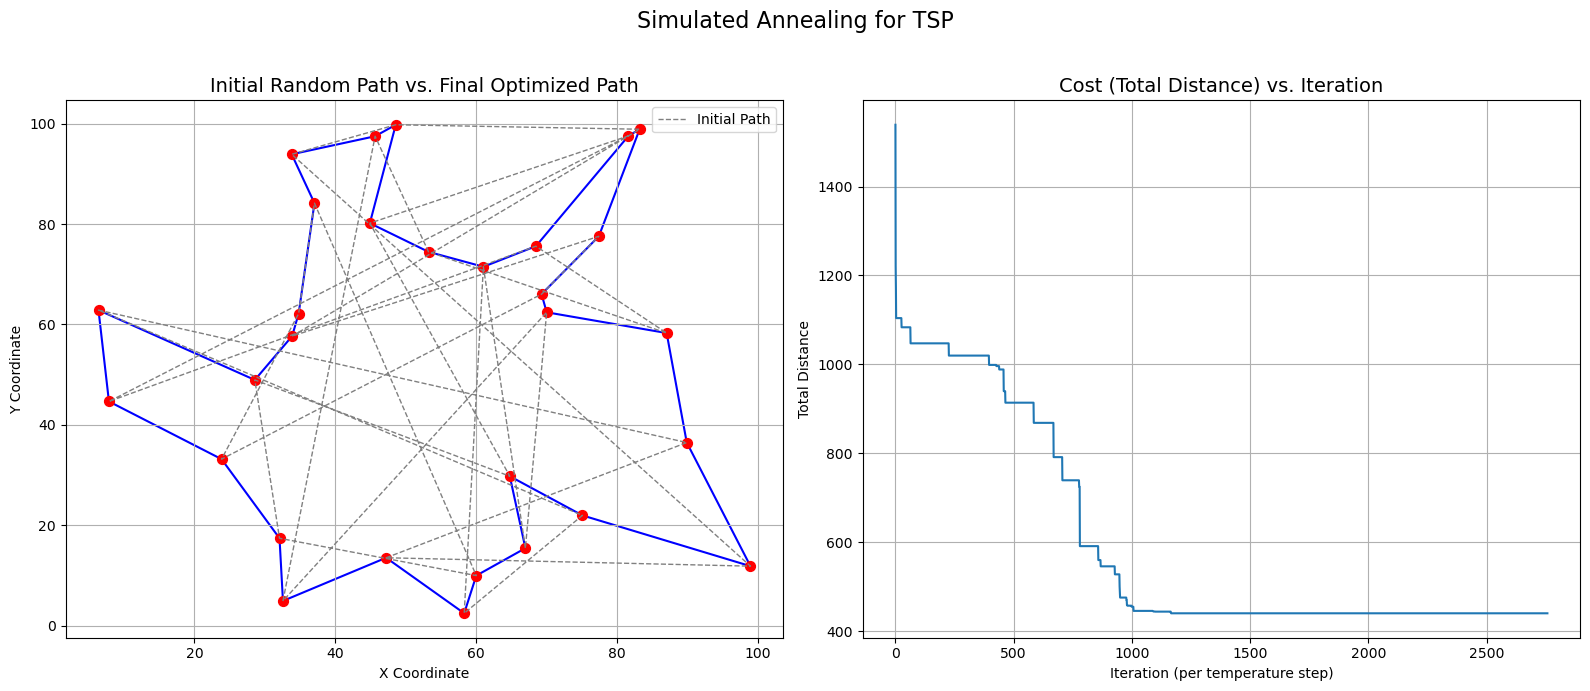

In [4]:

# 创建画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Simulated Annealing for TSP', fontsize=16)

# 绘制路径图
def plot_path(ax, title, path, cities):
    ax.scatter(cities[:, 0], cities[:, 1], c='red', s=50, zorder=2)
    path_coords = np.array([cities[i] for i in path + [path[0]]]) # 闭合路径
    ax.plot(path_coords[:, 0], path_coords[:, 1], c='blue', linewidth=1.5, linestyle='-', zorder=1)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

# 图1：初始路径 vs 最终路径
plot_path(ax1, 'Initial Random Path vs. Final Optimized Path', best_path, cities)
# 用虚线绘制初始路径作为对比
initial_path_coords = np.array([cities[i] for i in initial_path + [initial_path[0]]])
ax1.plot(initial_path_coords[:, 0], initial_path_coords[:, 1], c='gray', linewidth=1, linestyle='--', label='Initial Path')
ax1.legend()


# 图2：成本（总距离）随迭代次数的变化
ax2.plot(cost_history)
ax2.set_title('Cost (Total Distance) vs. Iteration', fontsize=14)
ax2.set_xlabel('Iteration (per temperature step)')
ax2.set_ylabel('Total Distance')
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

四、结果解读与可视化分析

运行代码后，你会得到两张图：
左图：路径对比
红色圆点：代表30个城市的分布。
灰色虚线：是算法开始时随机生成的初始路径。你可以看到它非常混乱，线路交叉严重，显然不是一条好路径。
蓝色实线：是模拟退火算法结束后找到的最优路径。你会发现这条路径非常“平滑”，几乎没有线路交叉，总长度也大大缩短了。它清晰地展示了算法从一个糟糕的解进化到一个非常好的解的过程。
右图：成本变化曲线
Y轴：代表当前找到的最短路径的总距离。
X轴：代表迭代的轮次（每降温一次算一轮）。
曲线趋势：
初期：成本迅速下降。这是因为在高温下，算法很容易从非常糟糕的初始状态跳到好得多的状态。
中期：成本下降速度变缓，但仍然在稳步下降，并可能出现一些小的波动。这些波动意味着算法接受了一些“坏”的移动，以跳出局部最优。
后期：成本曲线变得非常平坦，几乎不再下降。这表示在低温下，算法已经收敛，很难再找到更好的解了，只是在当前最优解附近做一些微小的调整。
这个例子完美地展示了模拟退火算法如何在一个极其复杂的、充满局部最优解的巨大搜索空间中，通过模拟物理降温的智慧，一步步找到一个高质量的全局近似最优解。